In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from utils.utils import *
from utils.dataset import XRayDataset
from utils.transform import *

# CUDA

In [2]:
def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset and Dataloader

In [4]:
df_train = pd.read_csv('data/train_undersampling.csv')
df_test = pd.read_csv('data/test.csv')
df_val = pd.read_csv('data/val.csv')

transform = MorphTransform(kernel_size=3)

train_dataset = XRayDataset(df_train, transform)
test_dataset = XRayDataset(df_test, transform)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=True)

# Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(5, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(1296, 32)
        self.fc2 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.3)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2, min_lr=0.000001)

In [7]:
def train(dataloader):
    model.train()
    c=0
    correct=0
    total = 0
    acc = 0

    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        c=c+1
        correct+=loss.cpu().detach().numpy()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        acc += (predicted == labels).sum().item()
        
    return correct/c, acc/total

def test(dataloader):
    model.eval()
    c=0
    correct=0
    total = 0
    acc = 0

    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        c=c+1
        correct+=loss.cpu().detach().numpy()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        acc += (predicted == labels).sum().item()
    return correct/c, acc/total

In [8]:
train_matrix = {'loss':[], 'accuracy':[]}
test_matrix = {'loss':[], 'accuracy':[]}
epochs = 25
min_loss = 100
print('start train\n')

for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader)
    test_loss, test_acc = test(test_dataloader)
    train_matrix['loss'].append(train_loss)
    train_matrix['accuracy'].append(train_acc)
    test_matrix['loss'].append(test_loss)
    test_matrix['accuracy'].append(test_acc)
    scheduler.step(test_loss)
    print(f'Epoch: {epoch+1:03d}, Train CrossEntropy: {train_loss:.4f}, Test CrossEntropy: {test_loss:.4f}')
    print(f'            Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}\n')
    if min_loss > test_loss:
        min_loss = test_loss
        print('Minimum Loss: {}'.format(min_loss))
        torch.save(model.state_dict(), "model/morph/best4.pt")

start train

Epoch: 001, Train CrossEntropy: 0.6911, Test CrossEntropy: 0.6926
            Train Accuracy: 0.5078, Test Accuracy: 0.3782

Minimum Loss: 0.6925778687000275
Epoch: 002, Train CrossEntropy: 0.6797, Test CrossEntropy: 0.7046
            Train Accuracy: 0.6501, Test Accuracy: 0.3750

Epoch: 003, Train CrossEntropy: 0.6617, Test CrossEntropy: 0.6701
            Train Accuracy: 0.5767, Test Accuracy: 0.5833

Minimum Loss: 0.6700604557991028
Epoch: 004, Train CrossEntropy: 0.6232, Test CrossEntropy: 0.6257
            Train Accuracy: 0.6706, Test Accuracy: 0.7965

Minimum Loss: 0.6256833672523499
Epoch: 005, Train CrossEntropy: 0.5340, Test CrossEntropy: 0.5359
            Train Accuracy: 0.8694, Test Accuracy: 0.8109

Minimum Loss: 0.5359253287315369
Epoch: 006, Train CrossEntropy: 0.4374, Test CrossEntropy: 0.4886
            Train Accuracy: 0.8872, Test Accuracy: 0.8157

Minimum Loss: 0.48859158158302307
Epoch: 007, Train CrossEntropy: 0.3377, Test CrossEntropy: 0.4509
     

In [9]:
torch.save(model.state_dict(), "model/morph/last4.pt")

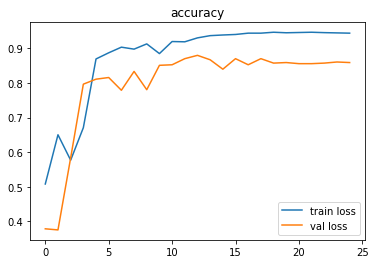

In [10]:
plt.title('accuracy')
plt.plot(np.arange(epochs), train_matrix['accuracy'], label='train loss')
plt.plot(np.arange(epochs), test_matrix['accuracy'], label='val loss')

plt.legend()
plt.show()

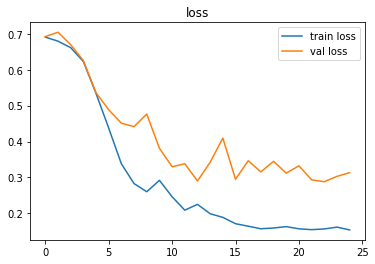

In [11]:
plt.title('loss')
plt.plot(np.arange(epochs), train_matrix['loss'], label='train loss')
plt.plot(np.arange(epochs), test_matrix['loss'], label='val loss')

plt.legend()
plt.show()

In [12]:
pickle.dump(train_matrix, open("model/morph/train_matrix4.pkl", "wb"))
pickle.dump(test_matrix, open("model/morph/test_matrix4.pkl", "wb"))

# Inference

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns

In [14]:
def show_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"]) # PD is Parkinson Disease
    plt.title("Confusion Matrix")
    plt.xlabel("predicted label")
    plt.ylabel("true label")

In [15]:
model_infer = Net().to(device)
model_infer.load_state_dict(torch.load("model/morph/best4.pt"))
model_infer.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [16]:
predict = []
actual = []
for i, data in enumerate(test_dataloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    # forward + backward + optimize
    outputs = model_infer(inputs)
    _, predicted = torch.max(outputs.data, 1)
    predict.append(predicted.cpu().detach().numpy())
    actual.append(labels.cpu().detach().numpy())
    
predict = np.concatenate(predict)
actual = np.concatenate(actual)

F1 Score: 0.8915956151035322
Accuracy: 0.8573717948717948
Precision: 0.8491879350348028
Recall: 0.9384615384615385


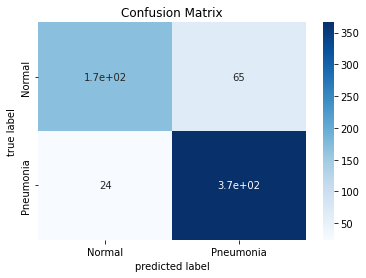

In [17]:
print(f"F1 Score: {f1_score(actual, predict)}")
print(f"Accuracy: {accuracy_score(actual, predict)}")
print(f"Precision: {precision_score(actual, predict)}")
print(f"Recall: {recall_score(actual, predict)}")

show_confusion_matrix(actual, predict)